In [1]:
import pandas as pd

In [107]:
train = pd.read_csv('./data/ratings_train.txt', sep='\t')
test = pd.read_csv('./data/ratings_test.txt', sep='\t')

In [65]:
for table in (train, test):
    print('데이터 개수')
    print(table.shape)

    print('nan 여부')
    print(table.isnull()['label'].unique())

    print('중복 데이터 개수')
    print(table.shape[0] - table['document'].nunique())

    print('클래스별 개수')
    print(table.groupby('label').size())

    print()

데이터 개수
(150000, 3)
nan 여부
[False]
중복 데이터 개수
3818
클래스별 개수
label
0    75173
1    74827
dtype: int64

데이터 개수
(50000, 3)
nan 여부
[False]
중복 데이터 개수
843
클래스별 개수
label
0    24827
1    25173
dtype: int64



# 실습
1. document 컬럼에서 중복 값을 제거합니다
1. document 컬럼에서 NaN 값을 제거합니다
1. document 컬럼에서 한글, 공백을 제외한 모든 텍스트를 제거합니다
1. 1~3번 전처리를 한 뒤, 비어있는 데이터를 제거합니다
2. 전처리가 끝난 뒤, 데이터 개수 변화를 확인합니다

In [109]:
for table in (train, test):
    table.drop_duplicates(subset=['document'], inplace=True)
    table['document'] = table['document'].str.replace('[^가-힣ㄱ-ㅎㅏ-ㅣ ]','',regex=True)
    table['document'] = table['document'].str.replace('[ +]','',regex=True)
    table['document'].replace('', float('nan'), inplace=True)
    table.dropna(how='any', inplace=True)

    print('전처리 후 데이터 개수:', table.shape)

전처리 후 데이터 개수: (145393, 3)
전처리 후 데이터 개수: (48852, 3)


C:\Users\user\AppData\Local\Temp\ipykernel_16132\2142432056.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  table['document'].replace('', float('nan'), inplace=True)


# 형태소 분석
1. 불용어 처리
2. 한 글자 단어는 제외하도록 합니다
3. train:test:valid=4000:2000:1000
4. train:test:valid 데이터의 각 클래스별 비율 확인하기
5. train set에서 등장하는 모든 단어 목록 확인하기

In [176]:
from konlpy.tag import Okt
from tqdm import tqdm
import numpy as np
from collections import Counter

okt = Okt()

In [ ]:
f = open('../stopwords-ko.txt', encoding='utf8')
stopwords = f.readlines()
stopwords = [s[:-1] for s in stopwords]

In [173]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [175]:
X_train = []
y_train = []

for i in tqdm(range(0,4000)):
    sentence = train['document'][i]
    y_train.append(train['label'][i])
    tokenized = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized if not word in stopwords and len(word) >= 2]
    if stopwords_removed_sentence == []: continue
    X_train.append(stopwords_removed_sentence)

X_test = []
y_test = []

for i in tqdm(range(0,2000)):
    sentence = test['document'][i]
    y_test.append(test['label'][i])
    tokenized = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized if not word in stopwords and len(word) >= 2]
    if stopwords_removed_sentence == []: continue
    X_test.append(stopwords_removed_sentence)

X_valid = []
y_valid = []

for i in tqdm(range(10000,11000)):
    sentence = test['document'][i]
    y_valid.append(test['label'][i])
    tokenized = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized if not word in stopwords and len(word) >= 2]
    if stopwords_removed_sentence == []: continue
    X_valid.append(stopwords_removed_sentence)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.60it/s]


In [209]:
for n in ('train', 'test', 'valid'):
    t = globals()['y_' + n]
    print(f'{n} 긍정 데이터 비율:', sum(t) / len(t))
    print(f'{n} 부정 데이터 비율:', sum(np.array(t) == 0) / len(t))
    print()

train 긍정 데이터 비율: 0.49925
train 부정 데이터 비율: 0.50075

test 긍정 데이터 비율: 0.5125
test 부정 데이터 비율: 0.4875

valid 긍정 데이터 비율: 0.495
valid 부정 데이터 비율: 0.505



In [ ]:
word_list = []

for sent in X_train:
    for word in sent:
        word_list.append(word)

word_counts = Counter(word_list)

len(word_counts)  # 고유한 단어 개수

word_counts['사람']  # '사람'이라는 단어가 등장한 빈도

vocab = sorted(word_counts, key=word_counts.get, reverse=True)

vocab[:10]  # 빈출 단어 10개

# 실습
1. 빈출 단어 시각화
2. 빈도가 3번 초과하지 않은 데이터는 제거
* 다 하신 분들은 파이토치 설치 미리 해 두세요. cpu버전으로 설치하면 됩니다

In [275]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [257]:
word_df = pd.DataFrame.from_dict(word_counts, orient='index')

In [263]:
word_df.sort_values(0, ascending=False, inplace=True)

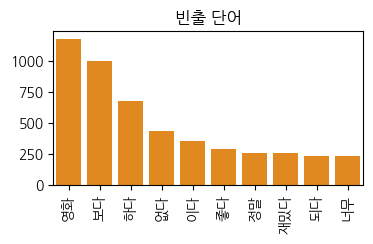

In [285]:
plt.subplots(figsize=(4,2))
sns.barplot(word_df.iloc[:10].T, color='darkorange')
plt.xticks(rotation=90)
plt.title('빈출 단어')
plt.show()

In [297]:
rm_list = []

for k, v in word_counts.items():
    if v <= 3:
        rm_list.append(k)

In [307]:
for X in ('X_train', 'X_test', 'X_valid'):
    globals()[X] = [[x2 for x2 in x if x2 not in rm_list] for x in globals()[X]]

In [315]:
for t in ('train', 'test', 'valid'):
    rng = len(globals()['X_' + t])

    globals()['X2_' + t] = []
    globals()['y2_' + t] = []
    for i in range(rng):
        if globals()['X_' + t][i] == []:
            continue
        else:
            globals()['X2_' + t].append(globals()['X_' + t][i])
            globals()['y2_' + t].append(globals()['y_' + t][i])

In [330]:
word_list = []

for sent in X2_train:
    for word in sent:
        word_list.append(word)

word_counts = Counter(word_list)

len(word_counts)  # 고유한 단어 개수

word_counts['사람']  # '사람'이라는 단어가 등장한 빈도

vocab = sorted(word_counts, key=word_counts.get, reverse=True)

vocab[:10]  # 빈출 단어 10개

['영화', '보다', '하다', '없다', '이다', '좋다', '정말', '재밌다', '되다', '너무']

In [324]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [326]:
word_to_index

{'<PAD>': 0, '<UNK>': 1}

In [338]:
for ind, word in enumerate(vocab):
    word_to_index[word] = ind + 2

In [346]:
# 정수 인코딩
def text_to_seq(X, word_to_index=word_to_index):
    X_enc = []

    for sent in X:
        ind_seq = []

        for word in sent:
            try:
                ind_seq.append(word_to_index[word])
            except KeyError:
                ind_seq.append(word_to_index['<UNK>'])

        X_enc.append(ind_seq)

    return X_enc

In [354]:
X2_train = text_to_seq(X2_train)
X2_test = text_to_seq(X2_test)
X2_valid = text_to_seq(X2_valid)

In [364]:
index_to_word = {}

for k, v in word_to_index.items():
    index_to_word[v] = k

In [368]:
# 디코딩
def seq_to_text(X, index_to_word=index_to_word):
    X_dec = []

    for sent in X:
        ind_seq = []

        for word in sent:
            ind_seq.append(index_to_word[word])

        X_dec.append(ind_seq)

    return X_dec

In [374]:
def pad_seq(sentences, max_len=30):
    features = np.zeros((len(sentences), max_len), dtype=int)

    for ind, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[ind, :len(sentence)] = np.array(sentence)[:max_len]

    return features

In [380]:
X_train_pad = pad_seq(X2_train)
X_test_pad = pad_seq(X2_test)
X_valid_pad = pad_seq(X2_valid)

In [382]:
import torch

In [384]:
device = torch.device('cpu')

In [412]:
train_label_tensor = torch.tensor(np.array(y2_train))
test_label_tensor = torch.tensor(np.array(y2_test))
valid_label_tensor = torch.tensor(np.array(y2_valid))

In [400]:
class TextClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: batch_size, seq_length
        embedded = self.embedding(x)

        lstm_out, (hidden, cell) = self.lstm(embedded)

        last_hidden = hidden.squeeze(0)
        logits = self.fc(last_hidden)
        return logits

In [402]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2  # binary
learning_rate = 0.01
num_epochs = 10
vocab_size = len(word_to_index)

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

TextClassifier(
  (embedding): Embedding(1374, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [414]:
encoded_train = torch.tensor(X_train_pad).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(X_test_pad).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=32)

encoded_valid = torch.tensor(X_valid_pad).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=32)

In [424]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [426]:
def calculate_acc(logits, labels):
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    acc = correct / total
    return acc

In [428]:
def evaluate(model, valid_dataloader, criterion=criterion, device=device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            logits = model(batch_X)
            loss = criterion(logits, batch_y)

            val_loss += loss.item()
            val_correct += calculate_acc(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_acc = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_acc

In [430]:
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss, train_correct, train_total = 0, 0, 0
    model.train()

    for batch_X, batch_y in train_dataloader:
        batch_x, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)
        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += calculate_acc(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_acc = train_correct / train_total
    train_loss /= len(train_dataloader)

    val_loss, val_acc = evaluate(model, valid_dataloader)

    print(f'epoch: {epoch+1} / {num_epochs}')
    print(f'train loss: {train_loss:.3f}, train acc.: {train_acc:.3f}')
    print(f'valid loss: {val_loss:.3f}, valid acc.: {val_acc:.3f}')

    if val_loss < best_val_loss:
        print(f'best val.loss saved; valid loss: {val_loss:.3f}, valid acc.: {val_acc:.3f}')
        best_val_loss = val_loss
        torch.save(model.state_dict(), './best_model.pth')

epoch: 0 / 10
train loss: 0.712, train acc.: 0.502
valid loss: 0.695, valid acc.: 0.507
best val.loss saved; valid loss: 0.695, valid acc.: 0.507
epoch: 1 / 10
train loss: 0.694, train acc.: 0.484
valid loss: 0.694, valid acc.: 0.493
best val.loss saved; valid loss: 0.694, valid acc.: 0.493
epoch: 2 / 10
train loss: 0.693, train acc.: 0.499
valid loss: 0.694, valid acc.: 0.506
epoch: 3 / 10
train loss: 0.693, train acc.: 0.498
valid loss: 0.693, valid acc.: 0.494
best val.loss saved; valid loss: 0.693, valid acc.: 0.494
epoch: 4 / 10
train loss: 0.693, train acc.: 0.494
valid loss: 0.694, valid acc.: 0.506
epoch: 5 / 10
train loss: 0.693, train acc.: 0.491
valid loss: 0.694, valid acc.: 0.494
epoch: 6 / 10
train loss: 0.692, train acc.: 0.502
valid loss: 0.696, valid acc.: 0.495
epoch: 7 / 10
train loss: 0.692, train acc.: 0.513
valid loss: 0.702, valid acc.: 0.486
epoch: 8 / 10
train loss: 0.691, train acc.: 0.526
valid loss: 0.694, valid acc.: 0.510
epoch: 9 / 10
train loss: 0.676, t

In [432]:
model.load_state_dict(torch.load('./best_model.pth'))

C:\Users\user\AppData\Local\Temp\ipykernel_16132\3794482924.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_model.pth'))


<All keys matched successfully>

In [434]:
model.to(device)

TextClassifier(
  (embedding): Embedding(1374, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [436]:
test_loss, test_acc = evaluate(model, test_dataloader)

In [438]:
print(test_loss, test_acc)

0.6933677513753215 0.5159655347187024


In [458]:
def predict(text, model, word_to_index=word_to_index):
    model.eval()

    tokens = okt.morphs(text, stem=True)
    tokens = [word for word in tokens if not word in stopwords]
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)

    with torch.no_grad():
        logits = model(input_tensor)

    pred_ind = torch.argmax(logits, dim=1)

    return pred_ind

In [478]:
if int(predict('싫어요', model)) == 0:
    print('부정적 리뷰')
else:
    print('긍정적 리뷰')

부정적 리뷰
